<a href="https://colab.research.google.com/github/mahdi943/cs_project/blob/develop/Training_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you choose Connect form upper right.


## 2) Load training dataset

*  Read from Keras library.



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, Flatten, GlobalAveragePooling2D
from keras.models import Model

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Dropout
from keras.regularizers import l2
from keras.regularizers import l1
np.random.seed(5)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from keras.utils.np_utils import to_categorical

In [ ]:
# import the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
#% matplotlib inline
from keras.preprocessing.image import load_img,img_to_array,array_to_img,save_img

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/project/dataset/train_new_brain.csv') 
data.head()

,name,class0,class1,class2,class3,box,txt
0,1.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",1
1,2.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",2
2,3.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",3
3,4.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",4
4,5.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",5


##4) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 model. This is pre-trained on ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of VGG-16 you will use for feature extraction. The very last classification layer (called "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

You'll also load the pretrained weights from ImageNet by specifying weights='imagenet'. 


In [ ]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(500, 500, 3))
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()

87924736/87910968 [==============================] - 0s 0us/step


By setting the trainable attribute to False, we ensure that the original (ImageNet) weights of the model will remain constant.

Note that it is possible to adjust the number of trainable layers by modifying the for loop.

We need a binary classifier (Male/Female) which we will add manually on top of the pre-trained model. This layer is usually called "classification head". Feel free to use the methods you learned in the class, i.e Dropout

In [ ]:
def brain_model(base_model, img_shape = (500,500,3)):
    
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)
    #X = Dropout(.5, img_shape)(X)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(.25)(X)
    # Define the new binary classification head 
    
    X = Dense(500, activation='relu', name='fc1')(X)
    X = Dropout(.25)(X)
    X = Dense(256, activation='relu', name='fc2')(X)
    X = Dropout(.25)(X)
    X = Dense(256, activation='relu', name='fc3')(X)
    X = Dropout(.25)(X)
    X = Dense(64, activation='relu', name='fc4')(X)
    X = Dropout(.25)(X)
        
    outputs = Dense(4,activation='softmax', name='predictions')(X)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
#Create your model using the function above

model = brain_model (base_model, img_shape = (500,500,3))

In [ ]:
model.summary()

## 7) Train the Network with  Tuned Parameters

In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/project/dataset/val_new_brain.csv') # enter the file path on your drive for the csv file
data1.head()

,name,class0,class1,class2,class3,box,txt
0,65.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",65
1,66.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",66
2,67.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",67
3,68.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",68
4,69.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",69


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Train.zip"

Archive:  /content/drive/MyDrive/project/dataset/Train.zip
   creating: Train/
  inflating: Train/1.jpg             
  inflating: Train/10.jpg            
  inflating: Train/101.jpg           
  inflating: Train/102.jpg           
  inflating: Train/103.jpg           
  inflating: Train/104.jpg           
  inflating: Train/105.jpg           
  inflating: Train/106.jpg           
  inflating: Train/107.jpg           
  inflating: Train/108.jpg           
  inflating: Train/109.jpg           
  inflating: Train/11.jpg            
  inflating: Train/110.jpg           
  inflating: Train/111.jpg           
  inflating: Train/112.jpg           
  inflating: Train/113.jpg           
  inflating: Train/114.jpg           
  inflating: Train/115.jpg           
  inflating: Train/116.jpg           
  inflating: Train/117.jpg           
  inflating: Train/118.jpg           
  inflating: Train/119.jpg           
  inflating: Train/12.jpg            
  inflating: Train/120.jpg           
  inflati

In [ ]:
y_col = ['class0', 'class1', 'class2', 'class3']

##2.1) Preparing the Dataset

In [ ]:
batch_size = 16
#FOLDER_PATH = Enter the path of the folder that contains images
data_path = "/content/Train" #where you extracted the zip file

#Should augmentations be the same for training and validation? 
#train_aug = ImageDataGenerator(rescale=1./255, ...)
#valid_aug = ImageDataGenerator(rescale=1./255, ...)

#shuffle the data
data = data.sample(frac=1)
data.reset_index(drop = True, inplace = True)
train_aug = ImageDataGenerator(rescale=1./255,         
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=False)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    dataframe=data,
    directory=data_path,
    x_col='name',
    y_col= y_col,
    class_mode="raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size)




Found 256 validated image filenames.


In [ ]:
# cd C:/Users/Asus/Downloads/cropped images/Valid

C:\Users\Asus\Downloads\cropped images\Valid


In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Valid.zip"

Archive:  /content/drive/MyDrive/project/dataset/Valid.zip
   creating: Valid/
  inflating: Valid/165.jpg           
  inflating: Valid/166.jpg           
  inflating: Valid/167.jpg           
  inflating: Valid/168.jpg           
  inflating: Valid/169.jpg           
  inflating: Valid/170.jpg           
  inflating: Valid/171.jpg           
  inflating: Valid/172.jpg           
  inflating: Valid/173.jpg           
  inflating: Valid/174.jpg           
  inflating: Valid/175.jpg           
  inflating: Valid/176.jpg           
  inflating: Valid/177.jpg           
  inflating: Valid/178.jpg           
  inflating: Valid/179.jpg           
  inflating: Valid/180.jpg           
  inflating: Valid/265.jpg           
  inflating: Valid/266.jpg           
  inflating: Valid/267.jpg           
  inflating: Valid/268.jpg           
  inflating: Valid/269.jpg           
  inflating: Valid/270.jpg           
  inflating: Valid/271.jpg           
  inflating: Valid/272.jpg           
  inflati

In [ ]:
data1

,name,class0,class1,class2,class3,box,txt
0,65.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",65
1,66.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",66
2,67.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",67
3,68.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",68
4,69.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",69
...,...,...,...,...,...,...,...
59,376.jpg,0,0,0,1,"[{'x_center': 250, 'y_center': 250, 'width': 4...",376
60,377.jpg,0,0,0,1,"[{'x_center': 250, 'y_center': 250, 'width': 4...",377
61,378.jpg,0,0,0,1,"[{'x_center': 250, 'y_center': 250, 'width': 4...",378
62,379.jpg,0,0,0,1,"[{'x_center': 250, 'y_center': 250, 'width': 4...",379


In [ ]:
valid_generator = test_aug.flow_from_dataframe(
    dataframe=data1,
    directory="/content/Valid",
    x_col='name',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size
)

Found 64 validated image filenames.


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, batch_size= 16 ,epochs=15, validation_data = valid_generator, callbacks= callback)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
16/16 [==============================] - 22s 1s/step - loss: 3.2969 - accuracy: 0.2930 - val_loss: 1.1092 - val_accuracy: 0.5625
Epoch 2/15
16/16 [==============================] - 15s 956ms/step - loss: 1.1117 - accuracy: 0.4922 - val_loss: 0.7424 - val_accuracy: 0.5156
Epoch 3/15
16/16 [==============================] - 16s 966ms/step - loss: 0.7844 - accuracy: 0.6680 - val_loss: 0.2589 - val_accuracy: 0.9062
Epoch 4/15
16/16 [==============================] - 16s 969ms/step - loss: 0.3756 - accuracy: 0.8398 - val_loss: 0.0593 - val_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 15s 961ms/step - loss: 0.3939 - accuracy: 0.8945 - val_loss: 0.0554 - val_accuracy: 0.9844
Epoch 6/15
16/16 [==============================] - 16s 990ms/step - loss: 0.3146 - accuracy: 0.8789 - val_loss: 0.0748 - val_accuracy: 0.9844
Epoch 7/15
16/16 [==============================] - 16s 985ms/step - loss: 0.3955 - accuracy: 0.8867 - val_loss: 0.0890 - val_accuracy: 0.9844
Ep

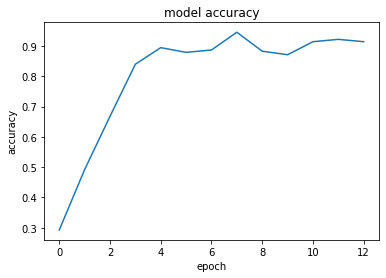

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['8', '16', '32', '128'], loc='upper left')
plt.savefig('Q1_multi.jpg')
plt.show()

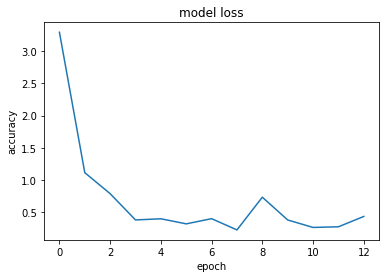

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['8', '16', '32', '128'], loc='upper left')
plt.savefig('Q1_multi.jpg')
plt.show()

In [ ]:
!unzip "/content/drive/MyDrive/project/dataset/Test.zip"
data2 = pd.read_csv('/content/drive/MyDrive/project/dataset/test_new_brain.csv') # enter the file path on your drive for the csv file
data2.head()

Archive:  /content/drive/MyDrive/project/dataset/Test.zip
   creating: Test/
  inflating: Test/100.jpg            
  inflating: Test/181.jpg            
  inflating: Test/182.jpg            
  inflating: Test/183.jpg            
  inflating: Test/184.jpg            
  inflating: Test/185.jpg            
  inflating: Test/186.jpg            
  inflating: Test/187.jpg            
  inflating: Test/188.jpg            
  inflating: Test/189.jpg            
  inflating: Test/190.jpg            
  inflating: Test/191.jpg            
  inflating: Test/192.jpg            
  inflating: Test/193.jpg            
  inflating: Test/194.jpg            
  inflating: Test/195.jpg            
  inflating: Test/196.jpg            
  inflating: Test/197.jpg            
  inflating: Test/198.jpg            
  inflating: Test/199.jpg            
  inflating: Test/200.jpg            
  inflating: Test/281.jpg            
  inflating: Test/282.jpg            
  inflating: Test/283.jpg            
  inflating

,name,class0,class1,class2,class3,box,txt
0,81.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",81
1,82.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",82
2,83.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",83
3,84.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",84
4,85.jpg,1,0,0,0,"[{'x_center': 250, 'y_center': 250, 'width': 4...",85


In [ ]:
test_generator = test_aug.flow_from_dataframe(
    dataframe=data2,
    directory="/content/Test",
    x_col='name',
    y_col= y_col,
    class_mode= "raw",
    target_size=(500,500), #this will resize the image, you can change the size
    batch_size=batch_size
)

Found 79 validated image filenames.


## 6) Test your classifier on Test set

- Apply same pre-processing as training data (Do not pre-processing with data augmentation here, pre-processing refers to operations like resizing, normalization)
- Predict the labels of testing data **using the best model that you have selected according to your validation results** and report the accuracy. 
- Construct a csv file with test predictions and submit it to SuCourse.

Please name the first column image_name and keep the name of the attributes as it is. (Do not change the order of the attributes). Name this file **submission.csv**

In [ ]:
from sklearn.metrics import accuracy_score
# Load test data
import csv 
from sklearn import metrics

data3 = pd.read_csv('/content/drive/MyDrive/project/dataset/test_brain.csv') # enter the file path on your drive for the csv file
data3.head()

y_predict = model.predict(test_generator)

y_predict = y_predict.argmax(-1)
accuracy_score(data3['label'],y_predict)
    


0.21518987341772153